# Estudio de la evolución de la pandemia por el modelo ARIMA para la isla de El Hierro

In [1]:
# Carga inicial de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
def visualizar_STL(df):
    stl = STL(df, period=12)
    res = stl.fit()
    
    fig = res.plot()

    
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator(interval=1))

    plt.xticks(rotation=90)
    plt.show()
    

def visualizar_adf(df):
    ''' Visualiza el p-valor del estudio de Dickey-Fuller para determinar la estacionalidad de los datos
    
    Args:
        df (DataFrame): DataFrame con los datos a realizar el estudio (DataFrame con una única columna que es la objetivo)
    '''

    adf = adfuller(df)
    print("ADF p-value:" + str(adf[1]))
    

def visualizar_acf(df, n_lags):
    plt.figure(figsize=(16, 10))
    plot_acf(df, lags=n_lags)
    plt.xlabel('Rezagos')
    plt.ylabel('Autocorrelación')
    plt.title('ACF')
    plt.show()
    
def visualizar_pacf(df, n_lags):
    plt.figure(figsize=(16, 6))
    plot_pacf(df, lags=n_lags)
    plt.xlabel('Rezagos')
    plt.ylabel('Autocorrelación parcial')
    plt.title('PACF')
    plt.show()
    
    
def visualizar_dif_pred_test(test, pred, variable, tit):
    ''' Método que visualiza un gráfico con la comparativa entre el número de casos reales y los predichos
    
    Args:
        test (DataFrame): Valores reales del conjunto de test
        pred (Serie): Valores predichos por el modelo
        variable(string): Variable objetivo
        tit(string): título del gráfico
    '''
    
    plt.figure(figsize=(10, 6))

    if variable != '':
        plt.plot(test.index, test[variable], label='Test', color='green')
    else:
        plt.plot(test.index, test, label='Test', color='green')
    plt.plot(test.index, pred, label='Predicción', color='orange')

    plt.gca().set_facecolor('lightgrey')
    plt.grid(True, linestyle='--', linewidth=0.5, color='white')
    plt.xticks(rotation=60)
    plt.legend()
    plt.title(tit)
    plt.xlabel('Fecha')
    plt.ylabel('Número de casos de COVID')
    plt.show()
    
def visualizar_historico(train, test, pred, variable, dias_historico, tit, color, dif):
    ''' Método que visualiza un gráfico con la comparativa entre el número de casos reales y los predichos
        y muestra el historico de casos en función del número de días que indiquemos que muestre
    
    Args:
        train (DataFrame): Conjunto de datos de entrenamiento
        test (DataFrame): Valores reales del conjunto de test
        pred (Serie): Valores predichos por el modelo
        variable (string): Variable objetivo
        dias_historico (integer): días hacia atrás a mostrar del historico
        tit (string): título del gráfico
        color (string): color de la isla para visualizar
    '''
    train_s = train.iloc[len(train) - dias_historico:]
    
    plt.figure(figsize=(10, 6))

    if variable != '':
        plt.plot(train_s.index, train_s[variable], label='Train', color=color)
        plt.plot(test.index, test[variable], label='Test', color='green')
    else:
        plt.plot(train_s.index, train_s, label='Train', color=color)
        plt.plot(test.index, test, label='Test', color='green')
    
    plt.plot(test.index, pred, label='Predicción', color='orange')
    plt.bar(test.index, dif, width=0.5, color='black', alpha=0.3, align='edge', edgecolor='black', label='Diferencia')
    
    
    plt.xticks(np.arange(0, len(train_s.index)  + len(test.index), step=5),   train_s.index.union(test.index)[::5], rotation=70)
    plt.gca().set_facecolor('lightgrey')
    plt.grid(True, linestyle='--', linewidth=0.5, color='white')
    plt.legend()
    plt.title(tit)
    plt.xlabel('Fecha')
    plt.ylabel('Número de casos de COVID')
    plt.show()
    
    
def obtener_errores(y_true, y_pred):
    ''' Método que devuelvo los errores:
            * MAE: Error absoluto medio
            * MSE: Error cuadrático medio
            * RMSE: Raíz del error cuadrático medio
    
    Args:
        y_true (Serie): Valores reales del conjunto de test
        y_pred (Serie): Valores predichos por el modelo
    Return:
        mae(float): Error absoluto medio
        mse(float): Error cuadrático medio
        rmse(float): Raíz del error cuadrático medio
    '''
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    return mae, mse, rmse

def visualizar_bic_aic(modelo):
    ''' Visualiza los datos de BIC (Criterio de Información Bayesiano) y  AIC (Criterio de Información de Akaike)
    
    Args:
        modelo (ARIMA): modelo ARIMA entrenado
    '''
    
    bic = modelo.bic
    aic = modelo.aic

    print("BIC del modelo ARIMA:", bic)
    print("AIC del modelo ARIMA:", aic)
    
def visualizar_resultados_texto(y_test, y_pred, variable):
    ''' Método que visualiza por pantalla en formato de texto el número de csaos reales y los predichos por el algoritmo
    
    Args:
        y_test (Serie): Valores reales del conjunto de test
        y_pred (Serie): Valores predichos por el modelo
        variable(string): Variable objetivo
    '''
    fechas = y_test.index
    for i in range(len(y_test)):
        if variable != '':
            valor_test = y_test[variable][i]
        else:
            valor_test = y_test[i] 
        print(str(fechas[i]) + ': número de casos reales ' + str(valor_test) + ', número de casos predichos ' + str(y_pred[i]))
        
def obtener_df_diferencias(test, pred, variable):
    df_result = test.copy()
    if variable != '':
        df_result = df_result[variable]
        df_result = df_result.to_frame()
    else:
        df_result = df_result.to_frame()
    df_result['pred'] = 0
    df_result['dif'] = 0

    for i in range(len(df_result)):
        df_result.iloc[i, df_result.columns.get_loc('pred')] = pred[i]
        df_result.iloc[i, df_result.columns.get_loc('dif')] = df_result['numero_casos'][i] - pred[i]
        
    return df_result

In [3]:
# Cargamos los datos de las estaciones de cada una de las islas
datos_islas = pd.read_csv('../data/Final/datos_reduc_final.csv', header=0)

# Obtenemos los datos de la isla a la que se le va a realizar el estudio
datos_ElHierro = datos_islas[datos_islas['isla'] == 'EL HIERRO'].copy()


datos_ElHierro = datos_ElHierro.sort_values(by='fecha')   # Ordenamos por fecha por si los datos devueltos no estuvieran en orden
datos_ElHierro.set_index('fecha', inplace=True)           # Añadimos como índice de los datos la fecha

In [4]:
objetivo = 'numero_casos' # Variable objetivo
n_dias = 10               # Numero de días correspondiente al conjunto de TEST
n_dias_train_vis = 100    # Número de días del conjunto de train a visualizar en el conjunto de train
color_isla = 'purple'     # Color de la isla en las visualizaciones
isla = 'El Hierro'        # Nombre de la isla para las visualizaciones    

variables_covid = ['pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19']   # Atributos para el análisis de las variables pandémicas
variables_atm = ['tmin', 'tmed', 'presMax']                         # Atributos para el análisis de las variables atmosféricas
variables = ['pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19','tmin', 'tmed', 'presMax'] # Atributos para el análisis de todas las variables

In [5]:
# Obtenemos los conjuntos de datos para cada modelo con las variables necesarias para cada uno de ellos

datos_ElHierro_arima_uni = datos_ElHierro[objetivo]               # Datos modelo Univariable
datos_ElHierro_arima_mult_covid = datos_ElHierro[[objetivo] + variables_covid] # Datos modelo Multivariable con datos pandémicos
datos_ElHierro_arima_mult_atm = datos_ElHierro[[objetivo] + variables_atm]     # Datos modelo Multivariable con datos atmosféricos
datos_ElHierro_arima_total = datos_ElHierro.copy()                # Datos modelo Multivariable con todos los datos

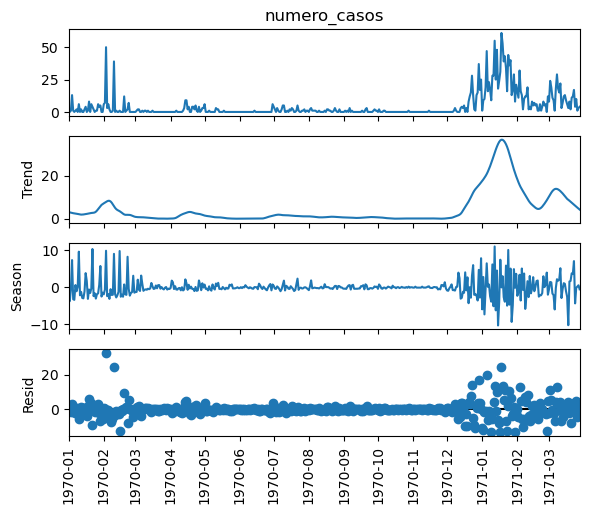

In [6]:
visualizar_STL(datos_ElHierro_arima_uni)

In [7]:
visualizar_adf(datos_ElHierro_arima_uni)

ADF p-value:0.055849165645199116


In [8]:
datos_ElHierro_arima_uni_1d = datos_ElHierro_arima_uni.diff().dropna()
visualizar_adf(datos_ElHierro_arima_uni_1d)

ADF p-value:1.2381611212624567e-07


<Figure size 1600x1000 with 0 Axes>

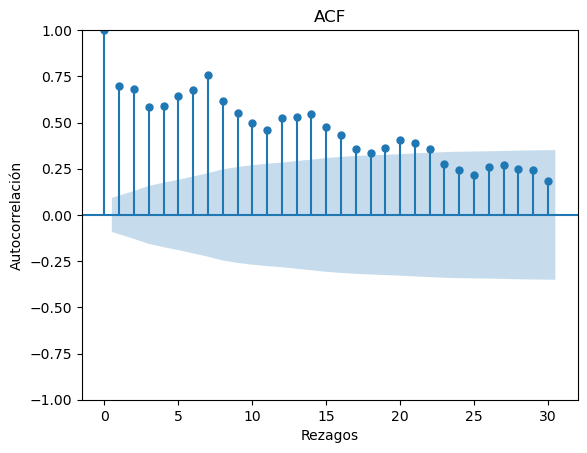

In [9]:
visualizar_acf(datos_ElHierro_arima_uni, 30)

<Figure size 1600x600 with 0 Axes>

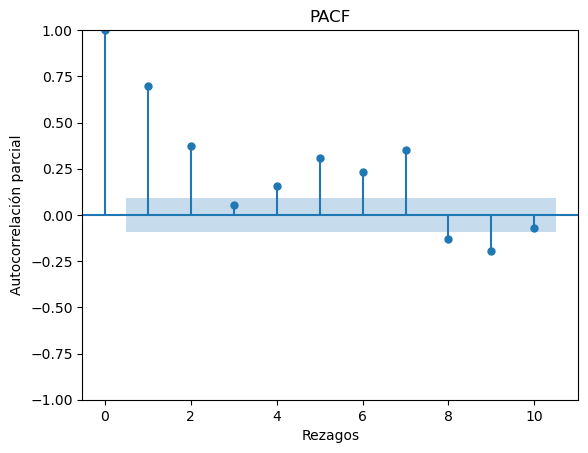

In [10]:
visualizar_pacf(datos_ElHierro_arima_uni, 10)

In [11]:
# Parámetros del modelo ARIMA
p = 3   # Parámetro Autorregresivo (AR)
d = 1   # Parámetro Integrado (I)
q = 3   # Parámetro Promedio Movil (MA)

# Modelo ARIMA univariable

In [12]:
# Conjuntos de entrenamiento y test
train = datos_ElHierro_arima_uni.iloc[:len(datos_ElHierro_arima_uni) - n_dias]
test =  datos_ElHierro_arima_uni.iloc[len(datos_ElHierro_arima_uni) - n_dias:]

In [13]:
arima_ElHierro = ARIMA(endog=train, order=(p, d, q), freq = 'D')
modelo_arima_ElHierro = arima_ElHierro.fit()

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [14]:
visualizar_bic_aic(modelo_arima_ElHierro)

BIC del modelo ARIMA: 2776.04141619002
AIC del modelo ARIMA: 2747.418102061892


In [15]:
pred = modelo_arima_ElHierro.forecast(steps=n_dias)
#pred = model_arima_tenerife.predict(start=test.index[0], end=test.index[-1])

In [16]:
visualizar_resultados_texto(test, pred, '')

2022-03-19: número de casos reales 8, número de casos predichos 3.1146910497053866
2022-03-20: número de casos reales 2, número de casos predichos 3.567003607309084
2022-03-21: número de casos reales 11, número de casos predichos 6.023141518681994
2022-03-22: número de casos reales 12, número de casos predichos 7.786184874220162
2022-03-23: número de casos reales 17, número de casos predichos 7.97774249351614
2022-03-24: número de casos reales 4, número de casos predichos 6.456056459200992
2022-03-25: número de casos reales 10, número de casos predichos 4.482531035398484
2022-03-26: número de casos reales 1, número de casos predichos 3.471478849215049
2022-03-27: número de casos reales 3, número de casos predichos 4.073892818320145
2022-03-28: número de casos reales 4, número de casos predichos 5.735257859326526


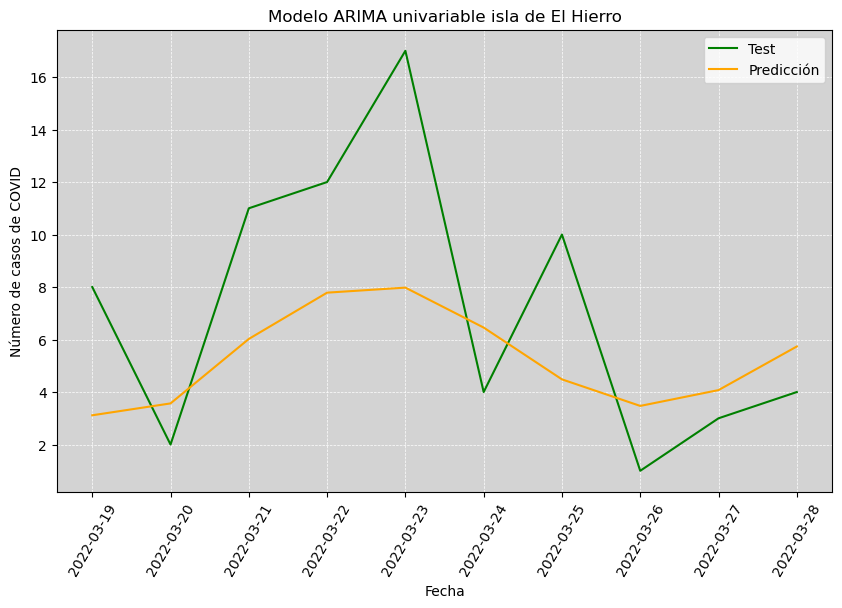

In [17]:
# Título para las visualizaciones
tit = 'Modelo ARIMA univariable isla de ' + isla
visualizar_dif_pred_test(test, pred, '', tit)

In [18]:
df_result = obtener_df_diferencias(test, pred, '')
df_result

,numero_casos,pred,dif
fecha,,,
2022-03-19,8,3.114691,4.885309
2022-03-20,2,3.567004,-1.567004
2022-03-21,11,6.023142,4.976858
2022-03-22,12,7.786185,4.213815
2022-03-23,17,7.977742,9.022258
2022-03-24,4,6.456056,-2.456056
2022-03-25,10,4.482531,5.517469
2022-03-26,1,3.471479,-2.471479
2022-03-27,3,4.073893,-1.073893


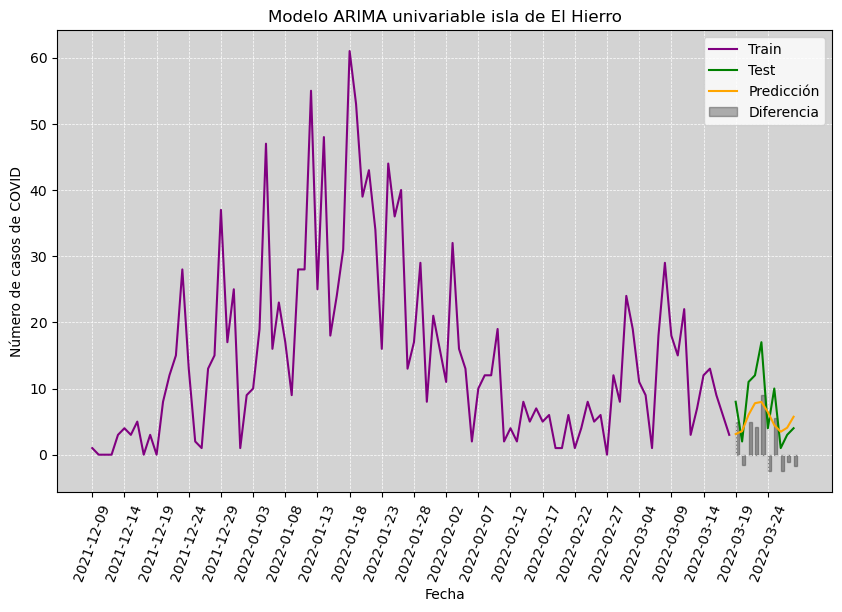

In [19]:
visualizar_historico(train, test, pred, '', n_dias_train_vis, tit, color_isla, df_result['dif'])

In [20]:
mae, mse, rmse = obtener_errores(test, pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 19.69954830476059
Error absoluto medio (MAE) del modelo: 3.791939862184963
Raíz del error cuadrático medio (RMSE) del modelo: 4.4384173198067565


# Modelo ARIMA multivariable con variables de pandemia

In [21]:
train = datos_ElHierro_arima_mult_covid.iloc[:len(datos_ElHierro_arima_mult_covid) - n_dias]
test =  datos_ElHierro_arima_mult_covid.iloc[len(datos_ElHierro_arima_mult_covid) - n_dias:]

In [22]:
arima_ElHierro = ARIMA(endog=train[objetivo],exog=train[variables_covid], order=(p, d, q), freq = 'D')
modelo_arima_ElHierro = arima_ElHierro.fit()

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [23]:
visualizar_bic_aic(modelo_arima_ElHierro)

BIC del modelo ARIMA: 2737.527800557527
AIC del modelo ARIMA: 2692.5483069276115


In [24]:
pred = modelo_arima_ElHierro.forecast(steps=n_dias, exog=test[variables_covid])

In [25]:
visualizar_resultados_texto(test, pred, objetivo)

2022-03-19: número de casos reales 8, número de casos predichos 4.991381796118661
2022-03-20: número de casos reales 2, número de casos predichos 2.9196426428631748
2022-03-21: número de casos reales 11, número de casos predichos 5.8756465213055815
2022-03-22: número de casos reales 12, número de casos predichos 5.332875492200267
2022-03-23: número de casos reales 17, número de casos predichos 7.875609262202175
2022-03-24: número de casos reales 4, número de casos predichos 3.006251541252312
2022-03-25: número de casos reales 10, número de casos predichos 4.020540631495402
2022-03-26: número de casos reales 1, número de casos predichos 2.351873319641627
2022-03-27: número de casos reales 3, número de casos predichos 2.932687857009933
2022-03-28: número de casos reales 4, número de casos predichos 2.571056028072078


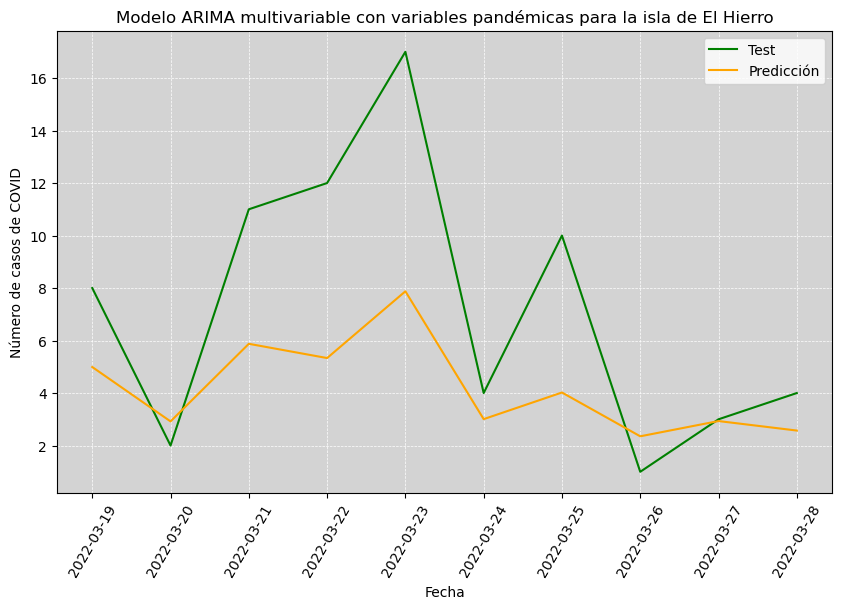

In [26]:
tit = 'Modelo ARIMA multivariable con variables pandémicas para la isla de ' + isla

visualizar_dif_pred_test(test, pred, objetivo, tit)

In [27]:
df_result = obtener_df_diferencias(test, pred, objetivo)
df_result

,numero_casos,pred,dif
fecha,,,
2022-03-19,8,4.991382,3.008618
2022-03-20,2,2.919643,-0.919643
2022-03-21,11,5.875647,5.124353
2022-03-22,12,5.332875,6.667125
2022-03-23,17,7.875609,9.124391
2022-03-24,4,3.006252,0.993748
2022-03-25,10,4.020541,5.979459
2022-03-26,1,2.351873,-1.351873
2022-03-27,3,2.932688,0.067312


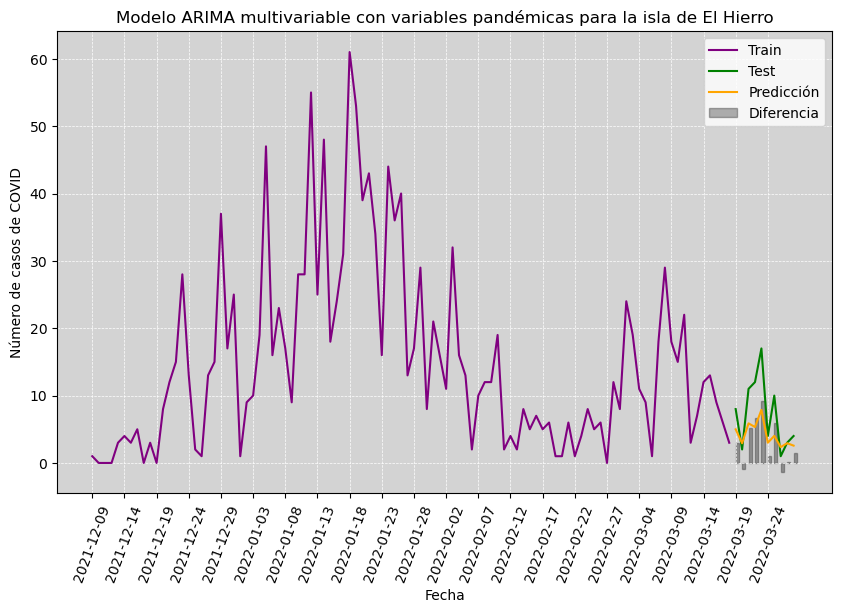

In [28]:
visualizar_historico(train, test, pred, objetivo, n_dias_train_vis, tit, color_isla, df_result['dif'])

In [29]:
mae, mse, rmse = obtener_errores(test[objetivo], pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 20.447702381114343
Error absoluto medio (MAE) del modelo: 3.4665466832848395
Raíz del error cuadrático medio (RMSE) del modelo: 4.521913575148727


# Modelo ARIMA multivariable con variables atmosféricas

In [30]:
train = datos_ElHierro_arima_mult_atm.iloc[:len(datos_ElHierro_arima_mult_atm) - n_dias]
test =  datos_ElHierro_arima_mult_atm.iloc[len(datos_ElHierro_arima_mult_atm) - n_dias:]

In [31]:
arima_ElHierro = ARIMA(endog=train[objetivo],exog=train[variables_atm], order=(p, d, q), freq = 'D')
modelo_arima_ElHierro = arima_ElHierro.fit()

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [32]:
visualizar_bic_aic(modelo_arima_ElHierro)

BIC del modelo ARIMA: 2791.8009470798875
AIC del modelo ARIMA: 2750.910498325419


In [33]:
pred = modelo_arima_ElHierro.forecast(steps=n_dias, exog=test[variables_atm])

In [34]:
visualizar_resultados_texto(test, pred, objetivo)

2022-03-19: número de casos reales 8, número de casos predichos 3.6111779346230897
2022-03-20: número de casos reales 2, número de casos predichos 3.66928898617493
2022-03-21: número de casos reales 11, número de casos predichos 6.226531986355983
2022-03-22: número de casos reales 12, número de casos predichos 7.858836240954194
2022-03-23: número de casos reales 17, número de casos predichos 7.819659639206073
2022-03-24: número de casos reales 4, número de casos predichos 6.259506711457515
2022-03-25: número de casos reales 10, número de casos predichos 4.606711017475536
2022-03-26: número de casos reales 1, número de casos predichos 4.098990753300772
2022-03-27: número de casos reales 3, número de casos predichos 4.487782601076464
2022-03-28: número de casos reales 4, número de casos predichos 6.114471926027171


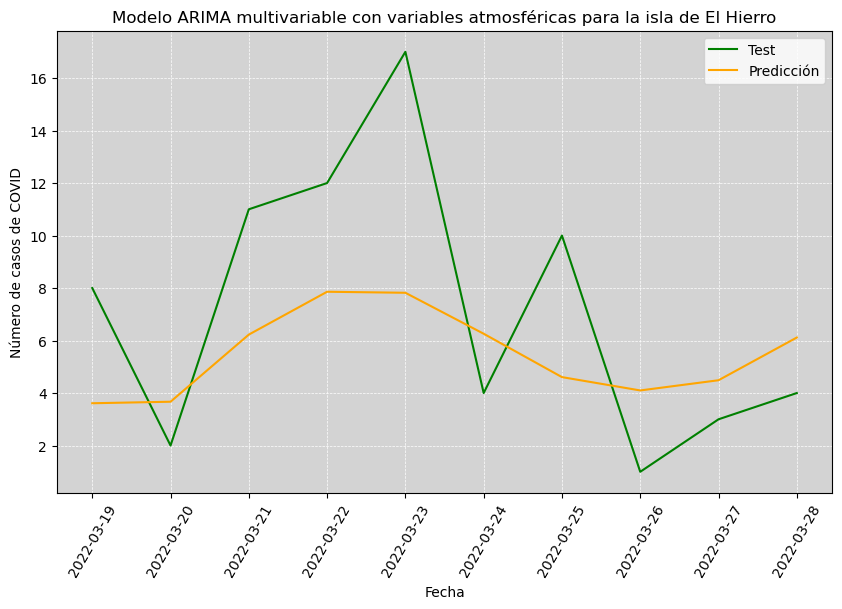

In [35]:
tit = 'Modelo ARIMA multivariable con variables atmosféricas para la isla de ' + isla

visualizar_dif_pred_test(test, pred, objetivo, tit)

In [36]:
df_result = obtener_df_diferencias(test, pred, objetivo)
df_result

,numero_casos,pred,dif
fecha,,,
2022-03-19,8,3.611178,4.388822
2022-03-20,2,3.669289,-1.669289
2022-03-21,11,6.226532,4.773468
2022-03-22,12,7.858836,4.141164
2022-03-23,17,7.819660,9.180340
2022-03-24,4,6.259507,-2.259507
2022-03-25,10,4.606711,5.393289
2022-03-26,1,4.098991,-3.098991
2022-03-27,3,4.487783,-1.487783


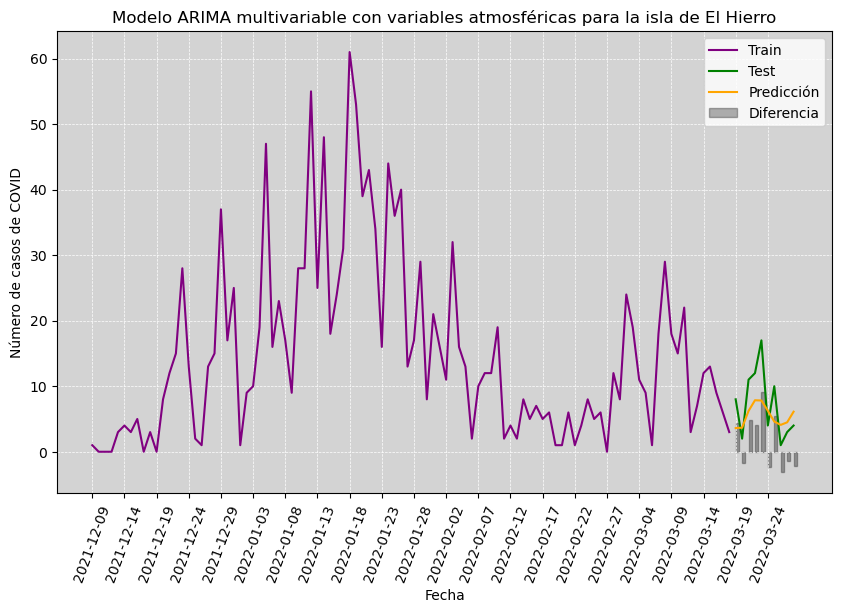

In [37]:
visualizar_historico(train, test, pred, objetivo, n_dias_train_vis, tit, color_isla, df_result['dif'])

In [38]:
mae, mse, rmse = obtener_errores(test[objetivo], pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 19.674333704865102
Error absoluto medio (MAE) del modelo: 3.850712415942197
Raíz del error cuadrático medio (RMSE) del modelo: 4.435575915804519


# Modelo ARIMA multivariable con todas las variables

In [39]:
train = datos_ElHierro_arima_total.iloc[:len(datos_ElHierro_arima_total) - n_dias]
test =  datos_ElHierro_arima_total.iloc[len(datos_ElHierro_arima_total) - n_dias:]

In [40]:
arima_ElHierro = ARIMA(endog=train[objetivo],exog=train[variables], order=(p, d, q), freq = 'D')
modelo_arima_ElHierro = arima_ElHierro.fit()

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [41]:
visualizar_bic_aic(modelo_arima_ElHierro)

BIC del modelo ARIMA: 2753.139906037088
AIC del modelo ARIMA: 2695.8932777808322


In [42]:
pred = modelo_arima_ElHierro.forecast(steps=10, exog=test[variables])

In [43]:
visualizar_resultados_texto(test, pred, objetivo)

2022-03-19: número de casos reales 8, número de casos predichos 4.69003835544936
2022-03-20: número de casos reales 2, número de casos predichos 2.622250516696468
2022-03-21: número de casos reales 11, número de casos predichos 5.8953498210119335
2022-03-22: número de casos reales 12, número de casos predichos 5.531399117227764
2022-03-23: número de casos reales 17, número de casos predichos 7.756779073650861
2022-03-24: número de casos reales 4, número de casos predichos 2.854096970089415
2022-03-25: número de casos reales 10, número de casos predichos 3.7579904270444615
2022-03-26: número de casos reales 1, número de casos predichos 2.2077973671558766
2022-03-27: número de casos reales 3, número de casos predichos 2.2472071513905547
2022-03-28: número de casos reales 4, número de casos predichos 2.220648889056747


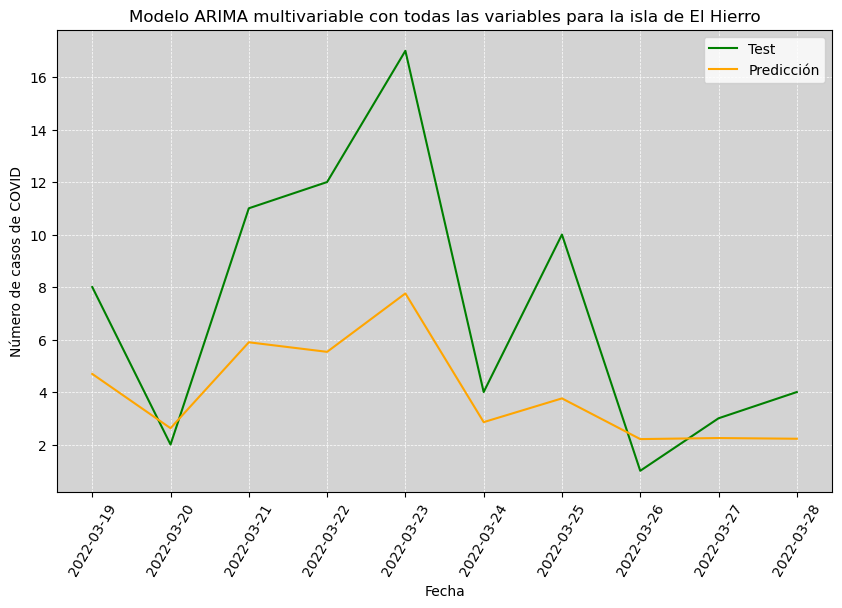

In [44]:
tit = 'Modelo ARIMA multivariable con todas las variables para la isla de ' + isla

visualizar_dif_pred_test(test, pred, objetivo, tit)

In [45]:
df_result = obtener_df_diferencias(test, pred, objetivo)
df_result

,numero_casos,pred,dif
fecha,,,
2022-03-19,8,4.690038,3.309962
2022-03-20,2,2.622251,-0.622251
2022-03-21,11,5.895350,5.104650
2022-03-22,12,5.531399,6.468601
2022-03-23,17,7.756779,9.243221
2022-03-24,4,2.854097,1.145903
2022-03-25,10,3.757990,6.242010
2022-03-26,1,2.207797,-1.207797
2022-03-27,3,2.247207,0.752793


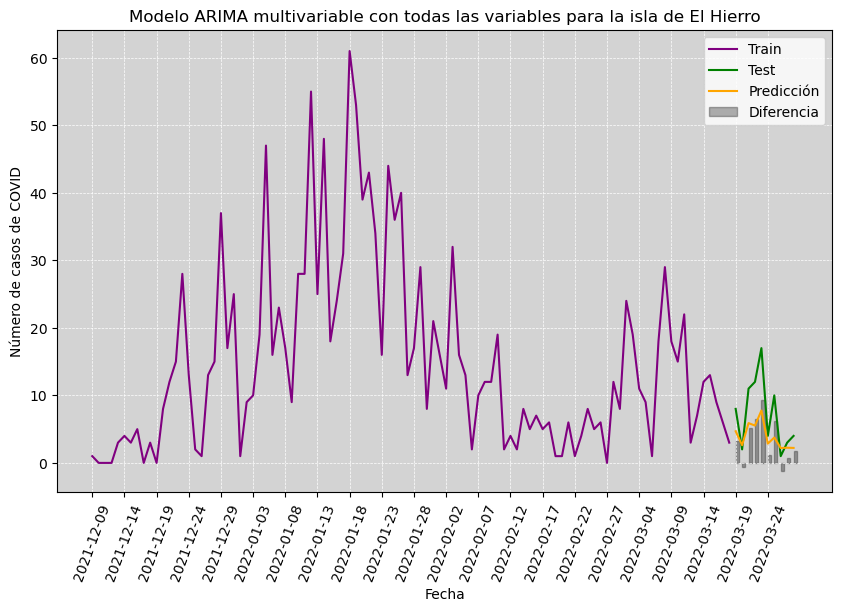

In [46]:
visualizar_historico(train, test, pred, objetivo, n_dias_train_vis, tit, color_isla, df_result['dif'])

In [47]:
mae, mse, rmse = obtener_errores(test[objetivo], pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 21.01477649095367
Error absoluto medio (MAE) del modelo: 3.587653807893125
Raíz del error cuadrático medio (RMSE) del modelo: 4.5841876587846695
